In [1]:
import numpy as np
import os
import pickle
import copy
import edt
import matplotlib.pyplot as plt
import time
import cv2
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from skimage.metrics import adapted_rand_error

import torch
from torch import from_numpy as from_numpy
from torchsummary import summary

from func.run_pipeline_super_vox import segment_super_vox_3_channel, semantic_segment_crop_and_cat_3_channel_output, img_3d_erosion_or_expansion, \
generate_super_vox_by_watershed, get_outlayer_of_a_3d_shape, get_crop_by_pixel_val, Cluster_Super_Vox, assign_boudary_voxels_to_cells_with_watershed, \
delete_too_small_cluster, reassign
from func.run_pipeline import segment, assign_boudary_voxels_to_cells, dbscan_of_seg, semantic_segment_crop_and_cat
from func.cal_accuracy import IOU_and_Dice_Accuracy, VOI
from func.network import VoxResNet, CellSegNet_basic_lite
from func.unet_3d_basic import UNet3D_basic
from func.ultis import save_obj, load_obj

# graph import stuff
from func.graph_learning import SuperVoxToNxGraph, VoxelGraphDataset, Cluster_Super_Vox_Graph
from func.graph_models import GCN

HMS_data_dict = load_obj("dataset_info/HMS_dataset_info")
HMS_data_dict_test = HMS_data_dict["test"]

print("Test cases: "+str(HMS_data_dict_test.keys()))
case = "135"
print("for test case "+str(case)+" : "+str(HMS_data_dict_test[case]))

# you may load the image using another path
raw_img=np.load(HMS_data_dict_test[case]["raw"]).astype(float)
hand_seg=np.load(HMS_data_dict_test[case]["ins"]).astype(float)

Using backend: pytorch


Test cases: dict_keys(['135', '120', '65', '90'])
for test case 135 : {'raw': 'data/CellSeg_dataset/HMS_processed/raw/135.npy', 'background': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_background_3d_mask.npy', 'boundary': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_boundary_3d_mask.npy', 'foreground': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_foreground_3d_mask.npy', 'ins': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_ins.npy'}


5reassign unique numbers progress: 0.7176470588235294

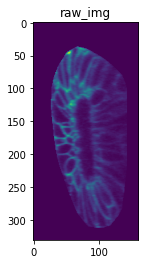

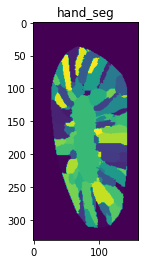

In [2]:
N=100

plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[N,:,:])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[N,:,:]))

raw img augmented shape: torch.Size([1, 181, 331, 160])
hand seg augmented shape: torch.Size([1, 181, 331, 160])
5

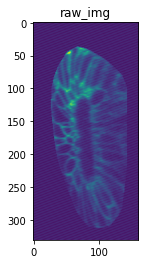

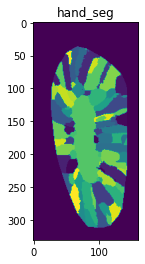

In [37]:
import torchio as tio

# Data Augmentation

def transform_the_tensor(image_tensors, prob=0.5):
    dict_imgs_tio={}

    for item in image_tensors.keys():
        dict_imgs_tio[item]=tio.ScalarImage(tensor=image_tensors[item])
    subject_all_imgs = tio.Subject(dict_imgs_tio)
    transform_shape = tio.Compose([
        tio.RandomFlip(axes = int(np.random.randint(3, size=1)[0]), p=1)
        #tio.RandomAffine(isotropic=True, degrees=(20,20,20))])#,tio.RandomAffine(p=prob)
        ])

    subject_all_imgs = transform_shape(subject_all_imgs)
    transform_val = tio.Compose([
        tio.RandomBlur(p=prob),
        tio.RandomNoise(p=prob),tio.RandomMotion(p=prob),tio.RandomBiasField(p=prob),tio.RandomSpike(p=prob),tio.RandomGhosting(p=prob)])
    subject_all_imgs['raw'] = transform_val(subject_all_imgs['raw'])

    for item in subject_all_imgs.keys():
        image_tensors[item] = subject_all_imgs[item].data

    return image_tensors

N=100

output = {
    'raw': np.expand_dims(raw_img, 0),
    'handseg': np.expand_dims(hand_seg, 0)
}
output_augmented = transform_the_tensor(output)
raw_img_augmented = output_augmented['raw']
hand_seg_augmented = output_augmented['handseg']

print(f"raw img augmented shape: {raw_img_augmented.shape}")
print(f"hand seg augmented shape: {hand_seg_augmented.shape}")

plt.figure()
plt.title("raw_img")
plt.imshow(raw_img_augmented[0,N,:,:])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg_augmented[0,N,:,:]))